# Weather Data Manipulation-0

Historical weather data is a key element of your model. In this notebook, we introduce old data from the snow farming project in Craftsbury. Specifically, we study mulch insulation, for which we have 4 temperature signals, at the surface of the snow, 10 cm in , on top of the insulation material and 46 cm above the pile.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import h5py
import pandas as pd
from pandas import Series

sensor811 = pd.read_excel("Insulation/SN 20103811 2018-07-16 13_18_09 -0400.xlsx",sheet_name="DATA",
                          header=1,date_parser=[1],names=["#","timestamp","probe1","probe2"])
sensor811 = sensor811.set_index('timestamp')
sensor811 = sensor811.drop("#",axis=1)
sensor934 = pd.read_excel("Insulation/SN 20366934 2018-07-16 13_19_37 -0400.xlsx",sheet_name="DATA",
                          header=1,date_parser=[0],names=["#","timestamp","probe1","probe2"])
sensor934 = sensor934.set_index('timestamp')
sensor934 = sensor934.drop("#",axis=1)

<AxesSubplot:xlabel='timestamp'>

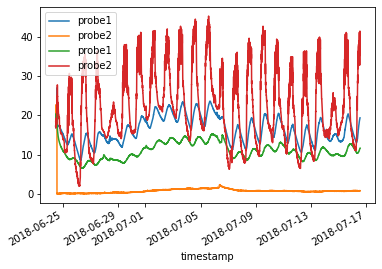

In [3]:
ax = sensor811.plot()
sensor934.plot(ax = ax)

In [ ]:
alt0 = np.copy(sensor811.probe2)
alt30 = np.copy(sensor811.probe1)
alt10 = np.copy(sensor934.probe1)
alt46 = np.copy(sensor934.probe2)
from scipy import signal
Ts = 5*60
freqs = 1/Ts

f,P0 = signal.periodogram(x=alt0[100:],fs=freqs, scaling='spectrum' )
f,P30 = signal.periodogram(x=alt30[100:],fs=freqs, scaling='spectrum' )
f1,P10 = signal.periodogram(x=alt10[100:],fs=freqs, scaling='spectrum' )
f1,P46 = signal.periodogram(x=alt46[100:],fs=freqs, scaling='spectrum' )

plt.loglog(f[1:]*24*3600,P0[1:])
plt.loglog(f1[1:]*24*3600,P10[1:])
plt.loglog(f[1:]*24*3600,P30[1:])
plt.loglog(f1[1:]*24*3600,P46[1:])
plt.xlabel(r'frequency [$Hz\times24h$]')
plt.ylabel(r'PSD [$T^2$]')
plt.ylim(1e-8,1e2)
plt.grid(True)
plt.show()

This plot shows the power spectra of the temperature signal. Power spectra are derived from Fourier series. The following should help to understand the physical meaning of power spectra.

<h1>Discrete Fourier Series</h1>

Consider a function $f$ periodic over a domain $0\leq x\leq 2\pi$, discretized by $N_x$ points. The longest wavelength wave that can be contained in the domain is $L_x$. A phyiscal understanding of Fourier series is the representation of a system as the sum of many waves fo wavelengths smaller or equal to $L_x$. In a discrete sense, the series of wave used to decompose the system is defined as:
$$
a_n\exp\left(\hat{\jmath}\frac{2\pi n}{Lx}\right)
$$
such that
<p class='alert alert-danger'>
$$
f(x) = \sum_{n=-\infty}^{\infty}a_n\exp\left(\hat{\jmath}\frac{2\pi nx}{Lx}\right)
$$
</p>
and 
<p class='alert alert-danger'>
$$
a_n = \frac{1}{L_x}\int_Lf(x)\exp\left(-\hat{\jmath}\frac{2\pi nx}{Lx}\right)dx
$$
</p>
Here $\hat{\jmath}^2=-1$.Often the reduction to wavenumber is used, where
<p class='alert alert-danger'>
$$
k_n = \frac{2\pi n}{L_x}
$$
</p>
Note that if $x$ is time instead of distance, $L_x$ is a time $T$ and the smallest frequency contained in the domain is $f_0=1/T_0$ and the wavenumber $n$ is $k_n=2\pi f_0n=2\pi f_n$ with $f_n$ for $\vert n\vert >1$ are the higher frequencies. 

<h1>Discrete Fourier Transform (DFT)</h1>

In scientific computing we are interested in applying Fourier series on vectors or matrices, containing a integer number of samples. The DFT is the fourier series for the number of samples. DFT functions available in python or any other language only care about the number of samples, therefore the wavenumber is 
<p class='alert alert-danger'>
$$
k_n=\frac{2\pi n}{N_x}
$$
</p>
Consider a function $f$ periodic over a domain $0\leq x\leq 2\pi$, discretized by $N_x$ points. The nodal value is $f_i$ located at $x_i=(i+1)\Delta x$ with $\Delta x=L_x/Nx$. The DFT is defined as
<p class='alert alert-danger'>
$$
\hat{f}_k=\sum_{i=0}^{N_x-1}f_i\exp\left(-2\pi\hat{\jmath}\frac{ik}{N_x}\right)
$$
</p>
The inverse DFT is defined as
<p class='alert alert-danger'>
$$
f_i=\sum_{k=0}^{N_x-1}\hat{f}_k\exp\left(2\pi\hat{\jmath}\frac{ik}{N_x}\right)
$$
</p>

<h1>Fast Fourier Transform (FFT)</h1>
Using symmetries, the FFT reduces computational costs and stores in the following way:
<p class='alert alert-danger'>
$$
\hat{f}_k=\sum_{i=-Nx/2+1}^{N_x/2}f_i\exp\left(-2\pi\hat{\jmath}\frac{ik}{N_x}\right)
$$
</p>
<p class='alert alert-info'>
Compared to the Fourier series, DFT or FFT assumes that the system can be accurately captured by a finite number of waves. It is up to the user to ensure that the number of computational points is sufficient to capture the smallest scale, or smallest wavelength or highest frequence. Remember that the function on which FT is applied must be periodic over the domain and the grid spacing must be uniform.
</p>
There are FT algorithms for unevenly space data, but this is beyond the scope of this notebook.


<h1>Filtering</h1>

The following provides examples of low- and high-pass filters based on Fourier transform. A ideal low-(high-) pass filter passes frequencies that are lower than a threshold without attenuation and removes frequencies that are higher than the threshold. 

When applied to spatial data (function of $x$ rather than $t$-time), the FT (Fourier Transform) of a variable is function of wavenumbers
$$
k_n=\frac{2\pi n}{L_x}
$$
or wavelengths
$$
\lambda_n=\frac{2\pi}{k_n}
$$

The test function is defined as sum of $N_{wave}$ cosine function:
$$
u(x)=\sum_{n=0}^{N_{wave}}A_n\cos\left(nx+\phi_n\right)
$$
with the following first and second derivatives:
$$
\frac{du}{dx}=\sum_{n=1}^{N_{wave}}-nA_n\sin\left(nx+\phi_n\right)
$$
$$
\frac{d^2u}{dx^2}=\sum_{n=1}^{N_{wave}}-n^2A_n\cos\left(nx+\phi_n\right)
$$
The python code for function u and its derivatives is written below. Here amplitudes $A_n$ and phases $\phi_n$ are chosen randomly of ranges $[0,1]$ and $[0,2\pi]$, respectively.

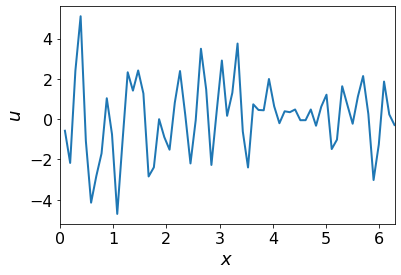

In [8]:
font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 18,
        }
import matplotlib.pyplot as plt
import numpy as np

Lx = 2.*np.pi
Nx = 64
u = np.zeros(Nx,dtype='float64')
du = np.zeros(Nx,dtype='float64')
ddu = np.zeros(Nx,dtype='float64')
k_0 = 2.*np.pi/Lx 
x = np.linspace(Lx/Nx,Lx,Nx)
Nwave = 24
uwave = np.zeros((Nx,Nwave),dtype='float64')
duwave = np.zeros((Nx,Nwave),dtype='float64')
dduwave = np.zeros((Nx,Nwave),dtype='float64')
ampwave = np.random.random(Nwave)
phasewave = np.random.random(Nwave)*2*np.pi
for iwave in range(Nwave):
    uwave[:,iwave] = ampwave[iwave]*np.cos(k_0*iwave*x+phasewave[iwave])
    duwave[:,iwave] = -k_0*iwave*ampwave[iwave]*np.sin(k_0*iwave*x+phasewave[iwave])
    dduwave[:,iwave] = -(k_0*iwave)**2*ampwave[iwave]*np.cos(k_0*iwave*x+phasewave[iwave])
u = np.sum(uwave,axis=1)
du = np.sum(duwave,axis=1)
ddu = np.sum(dduwave,axis=1)
#print(u)
plt.plot(x,u,lw=2)
plt.xlim(0,Lx)
#plt.legend(loc=3, bbox_to_anchor=[0, 1],
#           ncol=3, shadow=True, fancybox=True)
plt.xlabel('$x$', fontdict = font)
plt.ylabel('$u$', fontdict = font)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()
